In [4]:
#https://qiita.com/0NE_shoT_/items/b702ab482466df6e5569
#教科書

from sklearn import datasets
import pandas as pd
df = pd.read_csv('isigaki_miyako_iriomote_wavedata/isigaki_test.csv', header=None)

import numpy as np
from sklearn.preprocessing import LabelEncoder
#データのロード
X = df.loc[:, [1,4]].values
#print(X)
y = df.loc[:, 0].values

In [5]:
#データの分割（テスト用とトレーニング用）
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)
print('Labels counts in y[0 1]:', np.bincount(y))
print('Labels counts in y_train[0 1]:', np.bincount(y_train))
print('Labels counts in y_test[0 1]:', np.bincount(y_test))

Labels counts in y[0 1]: [4723   25]
Labels counts in y_train[0 1]: [3778   20]
Labels counts in y_test[0 1]: [945   5]


In [6]:
#標準化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print(X_train_std)

[[-0.77081914  1.38505558]
 [-1.06589257  2.52798994]
 [-0.52492461  1.52792238]
 ...
 [-0.57410352 -1.00081989]
 [ 0.55701132 -1.12940001]
 [-0.37738789  0.9564552 ]]


In [7]:
#pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print(X)

[[4.9  2.1 ]
 [4.9  1.9 ]
 [3.6  1.55]
 ...
 [6.2  9.5 ]
 [6.1  9.  ]
 [5.4  9.  ]]


In [8]:
#グラフをプロットするための関数
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In [9]:
#Scikit-learnによるロジスティック回帰
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=10) # ロジスティック回帰モデルのインスタンスを作成
lr.fit(X_train_std, y_train) # ロジスティック回帰モデルの重みを学習

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
#モデルの保存
import pickle
import os
dest = os.path.join('classifier','pkl-objects')#パスの結合
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(lr,
            open(os.path.join(dest,'Logistic.pkl'),
            'wb'))#'classifier/pkl-objects/ensemble.pklで保存)

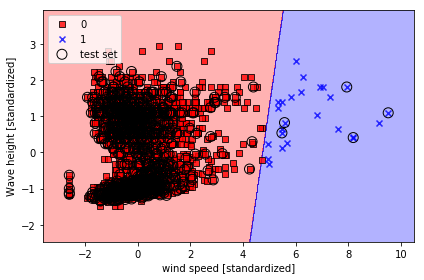

In [19]:
#ロジスティック回帰の結果のプロット（波の高さと風速の二つの特徴量のみ）
X_combined_std = np.vstack((X_train_std, X_test_std))#結合しているのはテストデータをランダムに取得したため
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=lr, test_idx=range(3798, 4748))#test_idx=range(105, 150)はテストデータの開始行数から終了行数まで
plt.xlabel('wind speed [standardized]')
plt.ylabel('Wave height [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

In [25]:
#パイプラインの作成
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        #PCA(n_components=2),
                        LogisticRegression(C=10))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 1.000


In [26]:
#K分割交差検証
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train_pca, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train_pca[train], y_train[train])
    score = pipe_lr.score(X_train_pca[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.5f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.5f +/- %.5f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [3400   18], Acc: 1.00000
Fold:  2, Class dist.: [3400   18], Acc: 1.00000
Fold:  3, Class dist.: [3400   18], Acc: 0.99737
Fold:  4, Class dist.: [3400   18], Acc: 1.00000
Fold:  5, Class dist.: [3400   18], Acc: 1.00000
Fold:  6, Class dist.: [3400   18], Acc: 1.00000
Fold:  7, Class dist.: [3400   18], Acc: 1.00000
Fold:  8, Class dist.: [3400   18], Acc: 1.00000
Fold:  9, Class dist.: [3401   18], Acc: 1.00000
Fold: 10, Class dist.: [3401   18], Acc: 1.00000

CV accuracy: 0.99974 +/- 0.00079


In [27]:
#交差検証でのモデルの正解率
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [1.         1.         0.99736842 1.         1.         1.
 1.         1.         1.         1.        ]
CV accuracy: 1.000 +/- 0.001


[[945   0]
 [  0   5]]


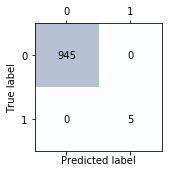

In [28]:
#混同行列
from sklearn.metrics import confusion_matrix

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [29]:
#適合率、再現率、F1スコア
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 1.000
Recall: 1.000
F1: 1.000


[[19.1   8.8 ]
 [16.4   7.05]
 [15.3   5.95]
 [ 2.2   1.7 ]
 [ 5.1   2.35]
 [14.1   6.2 ]]
データのクラス
[1 1 1 0 0 0]
forestモデルによるデータのクラス予想
[1 1 1 0 0 0]
データそれぞれに対するクラス[0 1]の所属解率
[[1.50435340e-02 9.84956466e-01]
 [1.97085156e-01 8.02914844e-01]
 [4.20019040e-01 5.79980960e-01]
 [9.99998870e-01 1.13022991e-06]
 [9.99973890e-01 2.61095041e-05]
 [7.39410085e-01 2.60589915e-01]]


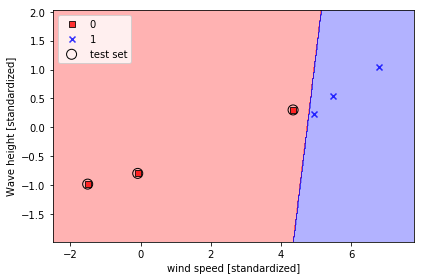

In [32]:
df1 = pd.read_csv('isigaki_miyako_iriomote_wavedata/test_1.csv', header=None)
X1 = df1.loc[:, [1,4]].values
#print(X)
y1 = df1.loc[:, 0].values
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.02, random_state=0)
print(X1)
X1_train_std = sc.transform(X1)
X1_train_pca = pca.fit_transform(X1_train_std)
predict = lr.predict(X1_train_std)
predict_proba = lr.predict_proba(X1_train_std)

#データに対する予測確率
print('データのクラス')
print(y1)
print('lrモデルによるデータのクラス予想')
print(predict)
print('データそれぞれに対するクラス[0 1]の所属解率')
print(predict_proba)

plt.figure(1)
#plot_data(X1_train_std, y1)


plot_decision_regions(X=X1_train_std, y=y1,
                      classifier=lr, test_idx=range(3, 6))#test_idx=range(105, 150)はテストデータの開始行数から終了行数まで
plt.xlabel('wind speed [standardized]')
plt.ylabel('Wave height [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()